# Probalistic Atlas - Medical Image Registration and Applications (MIRA)

This notebook contains all necessary code to create a probalistic atlas for medical image registration using elastix and transformix.

## 1. Imports

In [1]:
import os
import subprocess
from glob import glob
import math
from tqdm import tqdm
import pprint
import pandas as pd
import nibabel as nib
import numpy as np
from scipy.stats import pearsonr
from skimage import exposure
import matplotlib.pyplot as plt
import csv

pp = pprint.PrettyPrinter(indent=4)

## 2. Helper functions

In [2]:
def excute_cmd(command):
    # excute the command
    result = subprocess.run(command, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True, shell=True)

    # Check the return code to see if the command was successful
    if result.returncode == 0:
        # print("Command executed successfully.")
        # print("Output:")
        return result.stdout
    else:
        print(f"Command failed with an error: {command}")
        print(result.stderr)
        return result.stderr

def create_directory_if_not_exists(path):
    if not os.path.exists(path):
        os.makedirs(path)

def pprint_objects(*arg):
    '''Prints large and indented objects clearly.'''
    pp.pprint(arg)

def perform_histogram_matching(fixed_volume, moving_volume):
    # Ensure the volumes have the same shape
    if fixed_volume.shape != moving_volume.shape:
        raise ValueError("The fixed and moving volumes must have the same shape for histogram matching.")
    
    # Flatten the volumes for histogram matching
    fixed_flat = fixed_volume.ravel()
    moving_flat = moving_volume.ravel()
    
    # Perform histogram matching
    matched_moving_flat = exposure.match_histograms(moving_flat, fixed_flat)
    
    # Reshape the matched moving volume to its original shape
    matched_moving_volume = matched_moving_flat.reshape(moving_volume.shape)
    
    return matched_moving_volume

def replace_text_in_file(file_path, search_text, replacement_text):
    '''Function used to read a txt file, search for a given text, modify it, and save it in the same file.
    '''
    try:
        # Read the file
        with open(file_path, 'r') as file:
            content = file.read()

        # Replace the search_text with replacement_text
        modified_content = content.replace(search_text, replacement_text)

        # Write the modified content back to the file
        with open(file_path, 'w') as file:
            file.write(modified_content)

        print(f"Text replaced in {file_path} and saved.")
    except FileNotFoundError:
        print(f"File not found: {file_path}")
    # except Exception as e:
    #     print(f"An error occurred: {e}")

In [3]:
class NiftiManager:
    def __init__(self) -> None:
        pass

    def load_nifti(self, file_path):
        '''Loads the NIfTI image and access the image data as a Numpy array.'''
        nii_image = nib.load(file_path)
        data_array = nii_image.get_fdata()

        return data_array, nii_image

    def show_nifti(self, file_data, title, slice=25, export=False, filename=None):
        '''Displays a single slice from the nifti volume (change the slice index as needed).'''
        plt.imshow(file_data[:, :, slice], cmap='gray')
        # plt.title(title)
        # plt.colorbar()
        plt.axis('off')
        
        if export and filename:
            plt.savefig(filename)
            
        plt.show()

    def show_label_seg_nifti(self, label, seg, subject_id, slice=25):
        '''Displays both segmentation and ground truth labels as passed to the function.'''
        plt.figure(figsize=(20, 7))
        
        plt.subplot(1, 2, 1)
        plt.imshow(label[:, :, slice], cmap='gray') 
        plt.title(f'Label Image (Subject ID={subject_id})')
        plt.colorbar()

        plt.subplot(1, 2, 2)
        plt.imshow(seg[:, :, slice], cmap='gray') 
        plt.title(f'Segmentation Image (Subject ID={subject_id})')
        plt.colorbar()
        plt.show()

    def show_mean_volumes(self, mean_csf, mean_wm, mean_gm, slices=[128], export=False, filename=None):
        '''Displays the mean volumes for CSF, WM, and GM for a list of slices.'''
        num_slices = len(slices)
        
        # Increase font size and adjust figure size
        plt.figure(figsize=(12, 4 * num_slices))
        
        # Define font size for the titles
        title_font_size = 16
    
        for i, slice in enumerate(slices):
            plt.subplot(num_slices, 3, i * 3 + 1)
            plt.imshow(mean_csf[:, :, slice], cmap='gray')
            plt.title(f'Average CSF Volume - Slice {slice}', fontsize=title_font_size)
            plt.axis('off')
    
            plt.subplot(num_slices, 3, i * 3 + 2)
            plt.imshow(mean_wm[:, :, slice], cmap='gray')
            plt.title(f'Average WM Volume - Slice {slice}', fontsize=title_font_size)
            plt.axis('off')
    
            plt.subplot(num_slices, 3, i * 3 + 3)
            plt.imshow(mean_gm[:, :, slice], cmap='gray')
            plt.title(f'Average GM Volume - Slice {slice}', fontsize=title_font_size)
            plt.axis('off')
    
        # Adjust spacing between plots
        plt.tight_layout()
    
        if export and filename:
            plt.savefig(filename)
        
        plt.show()


    def show_combined_mean_volumes(self, mean_csf, mean_wm, mean_gm, slice_to_display=128, export=False, filename=None):
        # Stack the mean volumes along the fourth axis to create a single 4D array
        combined_mean_volumes = np.stack((mean_csf, mean_wm, mean_gm), axis=3)
    
        # Choose the channel you want to display (0 for CSF, 1 for WM, 2 for GM)
        channel_to_display = 0  # Adjust as needed
    
        # Display the selected channel
        plt.imshow(combined_mean_volumes[:, :, :, :][:, :, slice_to_display]) # [:, :, :, channel_to_display]
        plt.axis('off')  # Turn off axis labels
        # plt.title(f'Combined Averaged Volumes at Slice {slice_to_display}')  # Add a title

        if export and filename:
            plt.savefig(filename)
            
        plt.show()

    def min_max_normalization(self, image, max_value):
        # Ensure the image is a NumPy array for efficient calculations
        image = np.array(image)
        
        # Calculate the minimum and maximum pixel values
        min_value = np.min(image)
        max_actual = np.max(image)
        
        # Perform min-max normalization
        normalized_image = (image - min_value) / (max_actual - min_value) * max_value
        
        return normalized_image

    def export_nifti(self, volume, export_path):
        '''Exports nifti volume to a given path.
        '''
        
        # Create a NIfTI image from the NumPy array
        # np.eye(4): Identity affine transformation matrix, it essentially assumes that the images are in the same orientation and position 
        # as the original images
        img = nib.Nifti1Image(volume, np.eye(4))

        # Save the NIfTI image
        nib.save(img, str(export_path))

class Evaluate:
    def __init__(self) -> None:
        pass

    def calc_dice_coefficient(self, mask1, mask2):
        # Ensure the masks have the same shape
        if mask1.shape != mask2.shape:
            raise ValueError("Input masks must have the same shape.")

        # Compute the intersection and union of the masks
        intersection = np.sum(mask1 * mask2)
        union = np.sum(mask1) + np.sum(mask2)

        # Calculate the Dice coefficient
        dice = (2.0 * intersection) / (union + 1e-8)  # Add a small epsilon to avoid division by zero

        return dice

    def mutual_information(self, img_reg, img_fixed):
        '''Computes the mutual information metric between two images.'''
        hist_2d, x_edges, y_edges = np.histogram2d(img_reg.astype(np.double).ravel(),
                                               img_fixed.astype(np.double).ravel(),bins=20)
        # Convert bins counts to probability values
        pxy = hist_2d / float(np.sum(hist_2d))
        px = np.sum(pxy, axis=1) # marginal for x over y
        py = np.sum(pxy, axis=0) # marginal for y over x
        px_py = px[:, None] * py[None, :] # Broadcast to multiply marginals
        # Now we can do the calculation using the pxy, px_py 2D arrays
        nzs = pxy > 0 # Only non-zero pxy values contribute to the sum
        
        return np.sum(pxy[nzs] * np.log(pxy[nzs] / px_py[nzs]))
    
    def ncc(self, img1, img2, negative=False):
        '''Normalized cross-correlation implementation.
        '''
        # calculate the means of each image
        img1_mean = np.mean(img1)
        img2_mean = np.mean(img2)
    
        # calculate the numerator
        num = np.sum((img1 - img1_mean) * (img2 - img2_mean))
    
        # calculate the denominator
        p1 = np.sqrt(np.sum((img1 - img1_mean)**2))
        p2 = np.sqrt(np.sum((img2 - img2_mean)**2))
        denum = p1 * p2
        
        result = num / denum
    
        return 1 - result if negative else result # we substract by 1 as we use a minimizing optimizer

EVAL = Evaluate()
NM   = NiftiManager()

In [4]:
print(excute_cmd('elastix --help'))

elastix version: 5.000

elastix registers a moving image to a fixed image.
The registration-process is specified in the parameter file.
  --help, -h displays this message and exit
  --version  output version information and exit
  --extended-version  output extended version information and exit

Call elastix from the command line with mandatory arguments:
  -f        fixed image
  -m        moving image
  -out      output directory
  -p        parameter file, elastix handles 1 or more "-p"

Optional extra commands:
  -fMask    mask for fixed image
  -mMask    mask for moving image
  -t0       parameter file for initial transform
  -priority set the process priority to high, abovenormal, normal (default),
            belownormal, or idle (Windows only option)
  -threads  set the maximum number of threads of elastix

The parameter-file must contain all the information necessary for elastix to run properly. That includes which metric to use, which optimizer, which transform, etc. It must 

In [6]:
print(excute_cmd('transformix --help'))

transformix version: 5.000

transformix applies a transform on an input image and/or generates a deformation field.
The transform is specified in the transform-parameter file.
  --help, -h displays this message and exit
  --version  output version information and exit

Call transformix from the command line with mandatory arguments:
  -out      output directory
  -tp       transform-parameter file, only 1

Optional extra commands:
  -in       input image to deform
  -def      file containing input-image points; the point are transformed
            according to the specified transform-parameter file
            use "-def all" to transform all points from the input-image, which
            effectively generates a deformation field.
  -jac      use "-jac all" to generate an image with the determinant of the
            spatial Jacobian
  -jacmat   use "-jacmat all" to generate an image with the spatial Jacobian
            matrix at each voxel
  -priority set the process priority to high

## 3. Choosing the best suitable reference space

#### For us to find the best reference frame (fixed image) among the given datasets, we can measure some image quality and similarity metrics such as mutual information, signal to noise ratio (SNR), image sharpness, etc.. 
#### To start with the similarity metrics, as the mutual information, we need to register all images with all possible combinations to see how well images align with all combinations after the registration. The registration will be done using elastix command line, and some helper functions will be developed to ease the process of excuting and registering all images. 

For elastix, we need to specify the parameters files, which for our case will be both Par0010affine.txt and Par0010bspline.txt

In [7]:
reg_params = '-p "Par0010affine.txt" -p "Par0010bspline.txt"'

Experimenting with elastix with the `excute_cmd` function.

In [80]:
reg_fixed  = "training-set/training-images/1000.nii.gz"
reg_moving = "training-set/training-images/1001.nii.gz"
output_dir = f"output/output_{reg_fixed.split('/')[-1].split('.')[0]}/{reg_moving.split('/')[-1].split('.')[0]}"

# create elastix command line
command_line = f'elastix -f {reg_fixed} -m {reg_moving} -p "Par0010affine.txt" -p "Par0010bspline.txt" -out {output_dir}'

# run elastix 
# print(excute_cmd(command_line))

Lets get all images that we have for training

In [8]:
training_path = 'training-set/training-images'

training_volumes = sorted(glob(os.path.join(training_path, "*.nii.gz"), recursive=True))
pprint_objects(training_volumes)

# substract the length as we won't register the images with themselves
print('Total registrations: ', len(training_volumes)*len(training_volumes)-len(training_volumes)) 

(   [   'training-set/training-images\\1000.nii.gz',
        'training-set/training-images\\1001.nii.gz',
        'training-set/training-images\\1002.nii.gz',
        'training-set/training-images\\1006.nii.gz',
        'training-set/training-images\\1007.nii.gz',
        'training-set/training-images\\1008.nii.gz',
        'training-set/training-images\\1009.nii.gz',
        'training-set/training-images\\1010.nii.gz',
        'training-set/training-images\\1011.nii.gz',
        'training-set/training-images\\1012.nii.gz',
        'training-set/training-images\\1013.nii.gz',
        'training-set/training-images\\1014.nii.gz',
        'training-set/training-images\\1015.nii.gz',
        'training-set/training-images\\1017.nii.gz',
        'training-set/training-images\\1036.nii.gz'],)
Total registrations:  210


**Code below registers all images with all possible fixed combinations, run only when needed.**.	

In [11]:
# for fixed in tqdm(training_volumes):
#     for moving in training_volumes:
#         if fixed == moving: # to not register the image with its self
#             continue
            
#         # We register here, every image will be registered with all combinations except its self
#         reg_fixed  = fixed
#         reg_moving = moving

#         # Get the names of the fixed and moving images for the output directory, names without the file extensions
#         reg_fixed_name  = reg_fixed.split("\\")[-1].split(".")[0]
#         reg_moving_name = reg_moving.split("\\")[-1].split(".")[0]
        
#         # create an output folder using the image name in the output/images directory
#         # output folders structures
#         # output_{fixed_img_name}/{moving_image_name}/
#         output_dir = f'output/images/output_{reg_fixed_name}/{reg_moving_name}'

#         # creates the output directory
#         create_directory_if_not_exists(output_dir)

#         # create elastix command line
#         command_line = f'elastix -f "{reg_fixed}" -m "{reg_moving}" {reg_params} -out "{output_dir}"'

#         # run elastix on all combinations
#         excute_cmd(command_line)

 13%|████▏                          | 2/15 [13:48<1:29:21, 412.41s/it]

Command failed with an error: elastix -f "training-set/training-images\1002.nii.gz" -m "training-set/training-images\1006.nii.gz" -p "Par0010affine.txt" -p "Par0010bspline.txt" -out "output/images/output_1002/1006"

Command failed with an error: elastix -f "training-set/training-images\1002.nii.gz" -m "training-set/training-images\1017.nii.gz" -p "Par0010affine.txt" -p "Par0010bspline.txt" -out "output/images/output_1002/1017"



 20%|██████▏                        | 3/15 [20:13<1:19:57, 399.81s/it]

Command failed with an error: elastix -f "training-set/training-images\1006.nii.gz" -m "training-set/training-images\1002.nii.gz" -p "Par0010affine.txt" -p "Par0010bspline.txt" -out "output/images/output_1006/1002"



 27%|████████▎                      | 4/15 [27:09<1:14:28, 406.20s/it]

Command failed with an error: elastix -f "training-set/training-images\1007.nii.gz" -m "training-set/training-images\1002.nii.gz" -p "Par0010affine.txt" -p "Par0010bspline.txt" -out "output/images/output_1007/1002"



 80%|████████████████████████      | 12/15 [1:21:51<20:15, 405.03s/it]

Command failed with an error: elastix -f "training-set/training-images\1015.nii.gz" -m "training-set/training-images\1002.nii.gz" -p "Par0010affine.txt" -p "Par0010bspline.txt" -out "output/images/output_1015/1002"



 93%|████████████████████████████  | 14/15 [1:35:02<06:40, 400.40s/it]

Command failed with an error: elastix -f "training-set/training-images\1036.nii.gz" -m "training-set/training-images\1002.nii.gz" -p "Par0010affine.txt" -p "Par0010bspline.txt" -out "output/images/output_1036/1002"



100%|██████████████████████████████| 15/15 [1:41:47<00:00, 407.18s/it]


Some commands has failed, those failed to register will be excluded from the selection of being fixed images.

**Excluding 1002, 1006, 1007, 1015, 1036 from being fixed images as they fail in registering some volumes.**

In [10]:
training_volumes = [
    path for path in training_volumes if not any(name in path for name in ['1002', '1006', '1007', '1015', '1036'])
]
training_volumes

['training-set/training-images\\1000.nii.gz',
 'training-set/training-images\\1001.nii.gz',
 'training-set/training-images\\1008.nii.gz',
 'training-set/training-images\\1009.nii.gz',
 'training-set/training-images\\1010.nii.gz',
 'training-set/training-images\\1011.nii.gz',
 'training-set/training-images\\1012.nii.gz',
 'training-set/training-images\\1013.nii.gz',
 'training-set/training-images\\1014.nii.gz',
 'training-set/training-images\\1017.nii.gz']

##### Calculating the average Mutual Information (MI) for every fixed image registrations. The average is taken to take into accound all of the images being registered in a fixed range, 0 to 1. 

In [13]:
# mean mutual info list
mean_mutual_info_list = []

# correlation images lists
mean_correlation_list = []

# fixed images lists
fixed_images_list = []

for fixed in tqdm(training_volumes):
    # get the fixed image name
    reg_fixed_name  = fixed.split("\\")[-1].split(".")[0]

    # read the fixed image
    fixed_img, _ = NM.load_nifti(fixed)
    
    # set the output directory
    output_dir = f'output/images/output_{reg_fixed_name}'

    # get the registered volume in each directory
    registered_volumes = sorted(glob(os.path.join(output_dir, '**', "result.1.nii"), recursive=True))

    # mutual information list for each fixed
    mutual_info_list = []

    # correlation list for each fixed
    correlation_list = []

    for moving in registered_volumes:
        # read the moving image
        moving_img, _ = NM.load_nifti(moving)

        # append to a list
        mutual_info_list.append(EVAL.mutual_information(moving_img, fixed_img))
        correlation_list.append(EVAL.ncc(moving_img, fixed_img, negative=False))
    
    # compute the mean mutual information
    mean_mutual_info_list.append(np.mean(mutual_info_list))
    fixed_images_list.append(reg_fixed_name)
    mean_correlation_list.append(np.mean(correlation_list))

fixed_df            = pd.DataFrame(fixed_images_list, columns=["Fixed Image"])
mean_mutual_info_df = pd.DataFrame(mean_mutual_info_list, columns=["Average Mutual Information (MI)"])
mean_correlation_df = pd.DataFrame(mean_correlation_list, columns=["Average Normalized Cross-Correlation (NCC)"])

result_df = pd.concat([fixed_df, mean_mutual_info_df, mean_correlation_df], axis=1)
result_df = result_df.sort_values(by="Average Mutual Information (MI)", ascending=False)

result_df

100%|█████| 10/10 [03:24<00:00, 20.42s/it]


,Fixed Image,Average Mutual Information (MI),Average Normalized Cross-Correlation (NCC)
0,1000,0.544003,0.924832
9,1017,0.506419,0.916047
1,1001,0.506243,0.935060
4,1010,0.497656,0.932794
2,1008,0.491070,0.933131
5,1011,0.487106,0.932651
7,1013,0.443361,0.925239
3,1009,0.441582,0.931403
6,1012,0.434398,0.927540
8,1014,0.416701,0.929175


**Given the information above for the mean mutual informations, volume 1000 is the most suitable fixed image for building the atlas using Par0010affine.txt and Par0010bspline.txt parameters files .**

## 4. Transforming the labels based on the best reference space transformation files

In [11]:
# using the best image as fixed
fixed_image_path = 'training-set/training-images/1000.nii.gz'

In [52]:
# fixed image name
reg_fixed_name  = fixed_image_path.split("/")[-1].split(".")[0]

# set the output directory
output_dir = f'output/images/output_{reg_fixed_name}'

print("reg_fixed_name: " , reg_fixed_name)
print("output_dir: ", output_dir)

reg_fixed_name:  1000
output_dir:  output/images/output_1000


In [48]:
# get the transformation files from the output directory of the fixed image
transform_params = sorted(glob(os.path.join(output_dir, "***", "TransformParameters.1.txt"), recursive=True))
transform_params

['output/images/output_1000\\1001\\TransformParameters.1.txt',
 'output/images/output_1000\\1002\\TransformParameters.1.txt',
 'output/images/output_1000\\1006\\TransformParameters.1.txt',
 'output/images/output_1000\\1007\\TransformParameters.1.txt',
 'output/images/output_1000\\1008\\TransformParameters.1.txt',
 'output/images/output_1000\\1009\\TransformParameters.1.txt',
 'output/images/output_1000\\1010\\TransformParameters.1.txt',
 'output/images/output_1000\\1011\\TransformParameters.1.txt',
 'output/images/output_1000\\1012\\TransformParameters.1.txt',
 'output/images/output_1000\\1013\\TransformParameters.1.txt',
 'output/images/output_1000\\1014\\TransformParameters.1.txt',
 'output/images/output_1000\\1015\\TransformParameters.1.txt',
 'output/images/output_1000\\1017\\TransformParameters.1.txt',
 'output/images/output_1000\\1036\\TransformParameters.1.txt']

In [59]:
# get the labels
labels_path = 'training-set/training-labels'

training_labels = sorted(glob(os.path.join(labels_path, "*.nii.gz"), recursive=True))
training_labels

['training-set/training-labels\\1000_3C.nii.gz',
 'training-set/training-labels\\1001_3C.nii.gz',
 'training-set/training-labels\\1002_3C.nii.gz',
 'training-set/training-labels\\1006_3C.nii.gz',
 'training-set/training-labels\\1007_3C.nii.gz',
 'training-set/training-labels\\1008_3C.nii.gz',
 'training-set/training-labels\\1009_3C.nii.gz',
 'training-set/training-labels\\1010_3C.nii.gz',
 'training-set/training-labels\\1011_3C.nii.gz',
 'training-set/training-labels\\1012_3C.nii.gz',
 'training-set/training-labels\\1013_3C.nii.gz',
 'training-set/training-labels\\1014_3C.nii.gz',
 'training-set/training-labels\\1015_3C.nii.gz',
 'training-set/training-labels\\1017_3C.nii.gz',
 'training-set/training-labels\\1036_3C.nii.gz']

In [60]:
# exclude the fixed label
training_labels = [
    path for path in training_labels if not any(name in path for name in [reg_fixed_name])
]
training_labels

['training-set/training-labels\\1001_3C.nii.gz',
 'training-set/training-labels\\1002_3C.nii.gz',
 'training-set/training-labels\\1006_3C.nii.gz',
 'training-set/training-labels\\1007_3C.nii.gz',
 'training-set/training-labels\\1008_3C.nii.gz',
 'training-set/training-labels\\1009_3C.nii.gz',
 'training-set/training-labels\\1010_3C.nii.gz',
 'training-set/training-labels\\1011_3C.nii.gz',
 'training-set/training-labels\\1012_3C.nii.gz',
 'training-set/training-labels\\1013_3C.nii.gz',
 'training-set/training-labels\\1014_3C.nii.gz',
 'training-set/training-labels\\1015_3C.nii.gz',
 'training-set/training-labels\\1017_3C.nii.gz',
 'training-set/training-labels\\1036_3C.nii.gz']

**Code below transforms all labels with using the best fixed, run only when needed.**	

In [63]:
for transform_path, input_label in tqdm(zip(transform_params, training_labels)):
    # modify the transformation parameter interpolator value
    replace_text_in_file(
        transform_path, 
        search_text = '(FinalBSplineInterpolationOrder 3)', 
        replacement_text =  '(FinalBSplineInterpolationOrder 0)')

    # get the name of the moving 
    reg_moving_name  = transform_path.split("\\")[-2].split(".")[0]
    
    # create an output directory for the labels
    output_dir = f'output/labels/output_{reg_fixed_name}/{reg_moving_name}'

    # creates the output directory
    create_directory_if_not_exists(output_dir)
    
    # create transformix command line
    command_line = f'transformix -in "{input_label}" -tp "{transform_path}"  -out "{output_dir}"'

    # run transformix on all combinations
    excute_cmd(command_line)

0it [00:00, ?it/s]

Text replaced in output/images/output_1000\1001\TransformParameters.1.txt and saved.


1it [00:03,  3.18s/it]

Text replaced in output/images/output_1000\1002\TransformParameters.1.txt and saved.


2it [00:06,  3.15s/it]

Text replaced in output/images/output_1000\1006\TransformParameters.1.txt and saved.


3it [00:09,  3.22s/it]

Text replaced in output/images/output_1000\1007\TransformParameters.1.txt and saved.


4it [00:13,  3.42s/it]

Text replaced in output/images/output_1000\1008\TransformParameters.1.txt and saved.


5it [00:16,  3.37s/it]

Text replaced in output/images/output_1000\1009\TransformParameters.1.txt and saved.


6it [00:19,  3.34s/it]

Text replaced in output/images/output_1000\1010\TransformParameters.1.txt and saved.


7it [00:23,  3.31s/it]

Text replaced in output/images/output_1000\1011\TransformParameters.1.txt and saved.


8it [00:26,  3.32s/it]

Text replaced in output/images/output_1000\1012\TransformParameters.1.txt and saved.


9it [00:29,  3.33s/it]

Text replaced in output/images/output_1000\1013\TransformParameters.1.txt and saved.


10it [00:33,  3.35s/it]

Text replaced in output/images/output_1000\1014\TransformParameters.1.txt and saved.


11it [00:36,  3.35s/it]

Text replaced in output/images/output_1000\1015\TransformParameters.1.txt and saved.


12it [00:39,  3.35s/it]

Text replaced in output/images/output_1000\1017\TransformParameters.1.txt and saved.


13it [00:43,  3.33s/it]

Text replaced in output/images/output_1000\1036\TransformParameters.1.txt and saved.


14it [00:46,  3.33s/it]


## 5. Creating the probalistic maps for each cluster

In [9]:
labels_output_path = 'output/labels'

transformed_labels_volumes = sorted(glob(os.path.join(labels_output_path, "**", "result.nii"), recursive=True))
transformed_labels_volumes

['output/labels\\output_1000\\1001\\result.nii',
 'output/labels\\output_1000\\1002\\result.nii',
 'output/labels\\output_1000\\1006\\result.nii',
 'output/labels\\output_1000\\1007\\result.nii',
 'output/labels\\output_1000\\1008\\result.nii',
 'output/labels\\output_1000\\1009\\result.nii',
 'output/labels\\output_1000\\1010\\result.nii',
 'output/labels\\output_1000\\1011\\result.nii',
 'output/labels\\output_1000\\1012\\result.nii',
 'output/labels\\output_1000\\1013\\result.nii',
 'output/labels\\output_1000\\1014\\result.nii',
 'output/labels\\output_1000\\1015\\result.nii',
 'output/labels\\output_1000\\1017\\result.nii',
 'output/labels\\output_1000\\1036\\result.nii']

In [10]:
print("total labels volumes: ", len(transformed_labels_volumes))

total labels volumes:  14


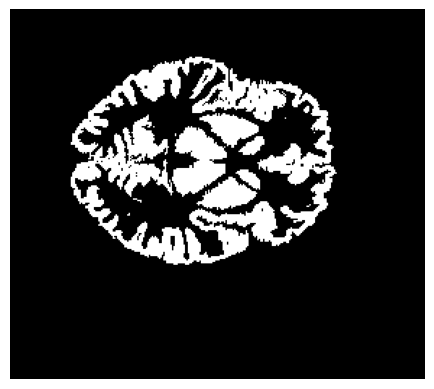

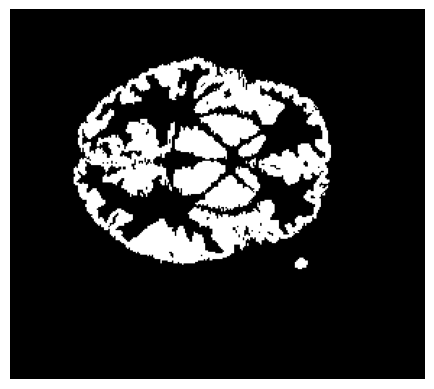

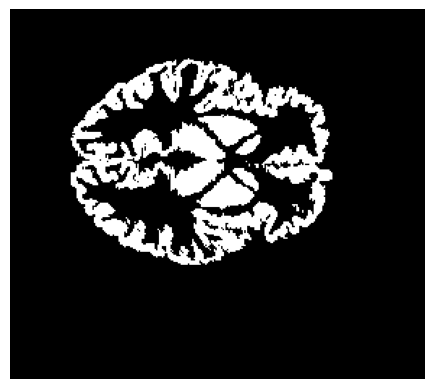

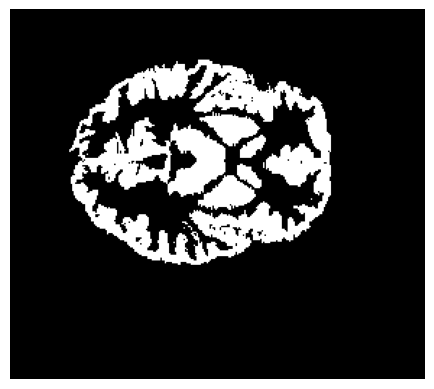

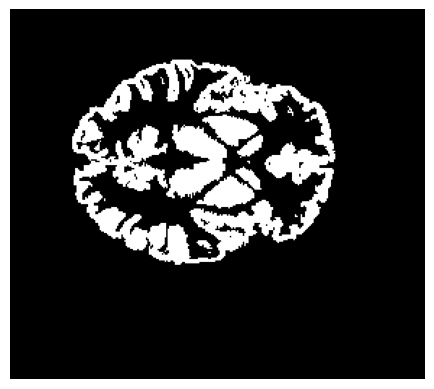

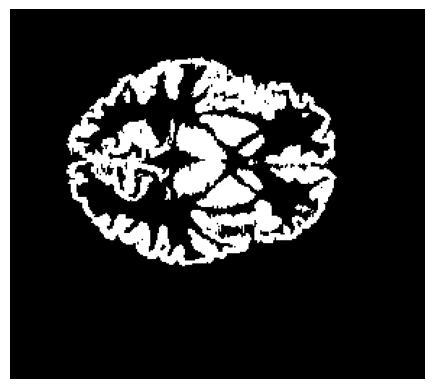

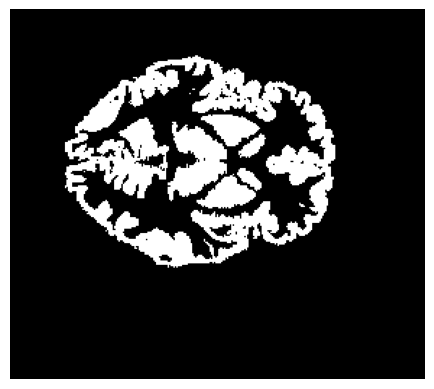

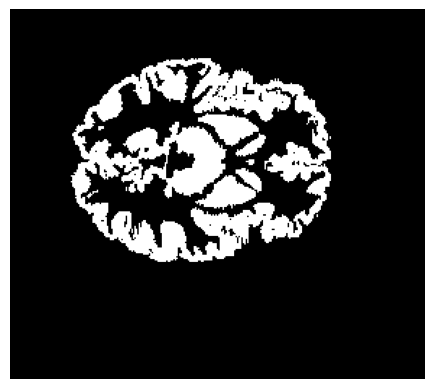

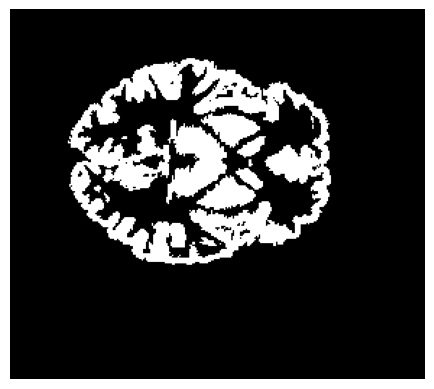

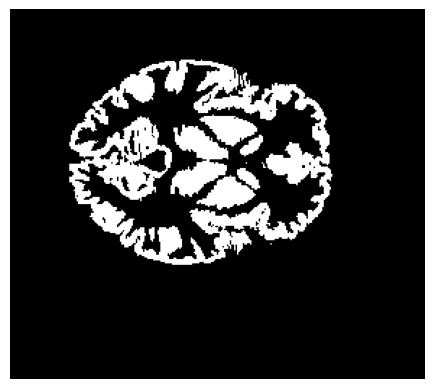

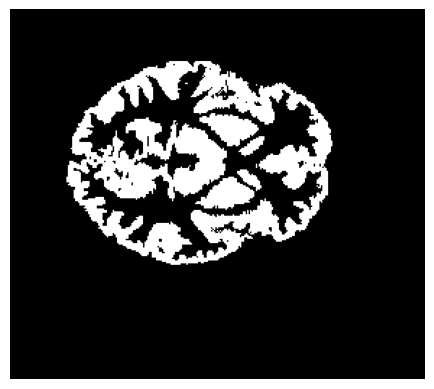

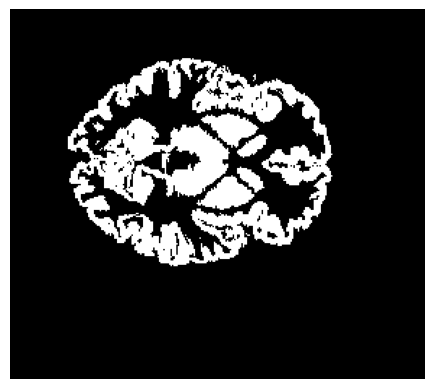

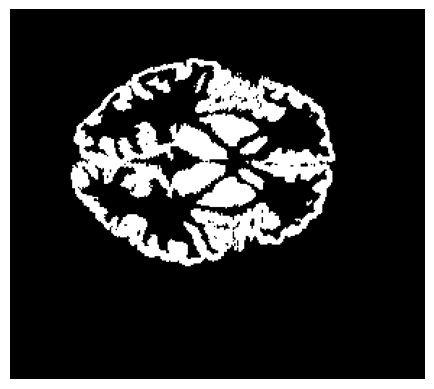

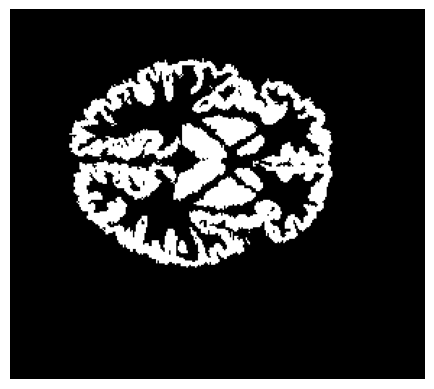

In [11]:
vol_nifti_csf_list  = [] # 1
vol_nifti_wm_list   = [] # 2
vol_nifti_gm_list   = [] # 3

for volume in transformed_labels_volumes:
    vol_nifti, _ = NM.load_nifti(volume)

    # display WM tissue
    vol_nifti_csf = vol_nifti == 1
    vol_nifti_wm  = vol_nifti == 2
    vol_nifti_gm  = vol_nifti == 3

    vol_nifti_csf_list.append(vol_nifti_csf)
    vol_nifti_wm_list.append(vol_nifti_wm)
    vol_nifti_gm_list.append(vol_nifti_gm)
    
    NM.show_nifti(vol_nifti_gm, title="Image ID: " + volume.split('\\')[-2] + f", Shape: {vol_nifti.shape}", slice=128)

In [12]:
# Calculate the mean volumes
mean_csf = np.mean(vol_nifti_csf_list, axis=0)
mean_wm = np.mean(vol_nifti_wm_list, axis=0)
mean_gm = np.mean(vol_nifti_gm_list, axis=0)

In [13]:
# checking the unique values of one of the means (max has to be 1)
unique_values_csf, counts = np.unique(mean_csf, return_counts=True)
print("unique_values_csf: ", unique_values_csf)
print("counts: ", counts)

unique_values_csf:  [0.         0.07142857 0.14285714 0.21428571 0.28571429 0.35714286
 0.42857143 0.5        0.57142857 0.64285714 0.71428571 0.78571429
 0.85714286 0.92857143 1.        ]
counts:  [18765259    10638     5302     3591     2733     2468     2002     1699
     1580     1457     1306     1466     1728     2495     5108]


In [14]:
print(mean_csf.shape)
print(mean_csf.dtype)

(256, 287, 256)
float64


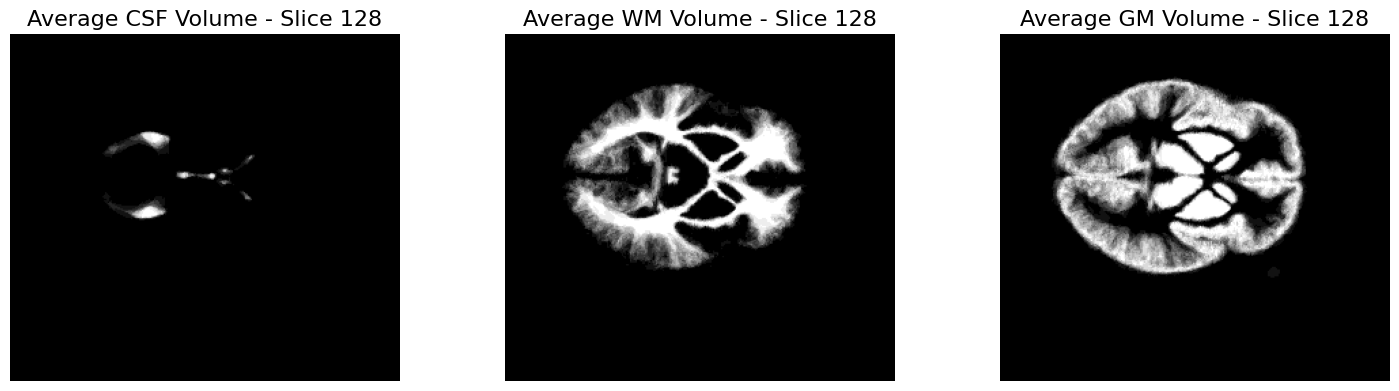

In [15]:
NM.show_mean_volumes(mean_csf, mean_wm, mean_gm, slices=[128])

In [140]:
# exporting each mean into a nifti volume
NM.export_nifti(volume = mean_csf, export_path = 'output/mean_csf.nii.gz')
NM.export_nifti(volume = mean_wm,  export_path = 'output/mean_wm.nii.gz')
NM.export_nifti(volume = mean_gm,  export_path = 'output/mean_gm.nii.gz')

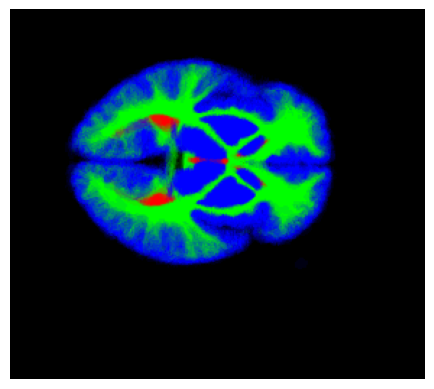

In [60]:
# Show combined probabilities as rgb
NM.show_combined_mean_volumes(mean_csf, mean_wm, mean_gm, slice_to_display=128)

## 6. Creating a mean intensity image using all transformed intensity images

In [4]:
# using the best image as fixed
fixed_image_path = 'training-set/training-images/1000.nii.gz'

# fixed image name
reg_fixed_name  = fixed_image_path.split("/")[-1].split(".")[0]

# set the output directory
output_dir = f'output/images/output_{reg_fixed_name}'

print("reg_fixed_name: " , reg_fixed_name)
print("output_dir: ", output_dir)

reg_fixed_name:  1000
output_dir:  output/images/output_1000


In [5]:
intensities_volumes = sorted(glob(os.path.join(output_dir, "**", "result.1.nii"), recursive=True))
intensities_volumes

['output/images/output_1000\\1001\\result.1.nii',
 'output/images/output_1000\\1002\\result.1.nii',
 'output/images/output_1000\\1006\\result.1.nii',
 'output/images/output_1000\\1007\\result.1.nii',
 'output/images/output_1000\\1008\\result.1.nii',
 'output/images/output_1000\\1009\\result.1.nii',
 'output/images/output_1000\\1010\\result.1.nii',
 'output/images/output_1000\\1011\\result.1.nii',
 'output/images/output_1000\\1012\\result.1.nii',
 'output/images/output_1000\\1013\\result.1.nii',
 'output/images/output_1000\\1014\\result.1.nii',
 'output/images/output_1000\\1015\\result.1.nii',
 'output/images/output_1000\\1017\\result.1.nii',
 'output/images/output_1000\\1036\\result.1.nii']

In [6]:
# we can add the fixed image to the intensity volumes when computing the average intensity volume
intensities_volumes.insert(0, fixed_image_path)
intensities_volumes

['training-set/training-images/1000.nii.gz',
 'output/images/output_1000\\1001\\result.1.nii',
 'output/images/output_1000\\1002\\result.1.nii',
 'output/images/output_1000\\1006\\result.1.nii',
 'output/images/output_1000\\1007\\result.1.nii',
 'output/images/output_1000\\1008\\result.1.nii',
 'output/images/output_1000\\1009\\result.1.nii',
 'output/images/output_1000\\1010\\result.1.nii',
 'output/images/output_1000\\1011\\result.1.nii',
 'output/images/output_1000\\1012\\result.1.nii',
 'output/images/output_1000\\1013\\result.1.nii',
 'output/images/output_1000\\1014\\result.1.nii',
 'output/images/output_1000\\1015\\result.1.nii',
 'output/images/output_1000\\1017\\result.1.nii',
 'output/images/output_1000\\1036\\result.1.nii']

In [7]:
vol_nifti_intensities = []

for volume_path in intensities_volumes:
    vol_nifti, _ = NM.load_nifti(volume_path)    
    vol_nifti_intensities.append(vol_nifti)

In [8]:
len(vol_nifti_intensities)

15

In [17]:
mean_intensity = np.mean(vol_nifti_intensities, axis=0, dtype=np.float32) # save as float32 for smaller size, default is float64

print(mean_intensity.shape, mean_intensity.dtype)

(256, 287, 256) float32


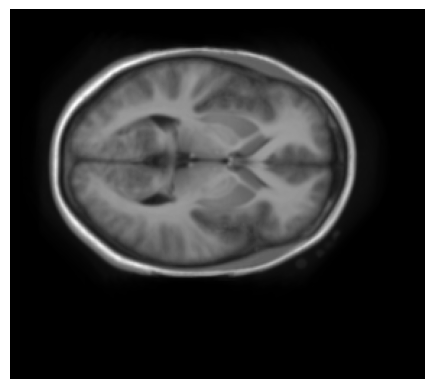

In [18]:
NM.show_nifti(mean_intensity, title=f"Mean Intensity Image, Shape: {mean_intensity.shape}", slice=128)

In [19]:
NM.export_nifti(volume = mean_intensity, export_path = 'output/mean_intensity.nii.gz')

## 7. Creating a tissue models using the training data

In [61]:
training_path = 'training-set/training-images'
labels_path = 'training-set/training-labels'

training_volumes = sorted(glob(os.path.join(training_path, "*.nii.gz"), recursive=True))
training_labels = sorted(glob(os.path.join(labels_path, "*.nii.gz"), recursive=True))

pprint_objects(training_volumes)
print('')
pprint_objects(training_labels)

(   [   'training-set/training-images\\1000.nii.gz',
        'training-set/training-images\\1001.nii.gz',
        'training-set/training-images\\1002.nii.gz',
        'training-set/training-images\\1006.nii.gz',
        'training-set/training-images\\1007.nii.gz',
        'training-set/training-images\\1008.nii.gz',
        'training-set/training-images\\1009.nii.gz',
        'training-set/training-images\\1010.nii.gz',
        'training-set/training-images\\1011.nii.gz',
        'training-set/training-images\\1012.nii.gz',
        'training-set/training-images\\1013.nii.gz',
        'training-set/training-images\\1014.nii.gz',
        'training-set/training-images\\1015.nii.gz',
        'training-set/training-images\\1017.nii.gz',
        'training-set/training-images\\1036.nii.gz'],)

(   [   'training-set/training-labels\\1000_3C.nii.gz',
        'training-set/training-labels\\1001_3C.nii.gz',
        'training-set/training-labels\\1002_3C.nii.gz',
        'training-set/training-lab

In [62]:
# Initialize empty histograms for each tissue class
hist_csf = np.zeros(255)
hist_wm = np.zeros(255)
hist_gm = np.zeros(255)
hist_bg = np.zeros(255) # we will ignore it

for train_dir, label_dir in tqdm(zip(training_volumes, training_labels)):
    train_img, _ = NM.load_nifti(train_dir)
    label_img, _ = NM.load_nifti(label_dir)

    # Intensity normallisation
    train_img = NM.min_max_normalization(train_img, 255).astype('uint8')    

    hist_bg  += np.histogram(train_img[label_img == 0], bins=255, range=[0,256])[0]
    hist_csf += np.histogram(train_img[label_img == 1], bins=255, range=[0,256])[0]
    hist_wm  += np.histogram(train_img[label_img == 2], bins=255, range=[0,256])[0]
    hist_gm  += np.histogram(train_img[label_img == 3], bins=255, range=[0,256])[0]

# normalizing the histograms by dividing them by the total count for each class.
hist_bg_norm  = hist_bg  /  np.sum(hist_bg, axis=0)
hist_csf_norm = hist_csf /  np.sum(hist_csf, axis=0)
hist_wm_norm  = hist_wm  /  np.sum(hist_wm,  axis=0)
hist_gm_norm  = hist_gm  /  np.sum(hist_gm,  axis=0)

15it [00:19,  1.28s/it]


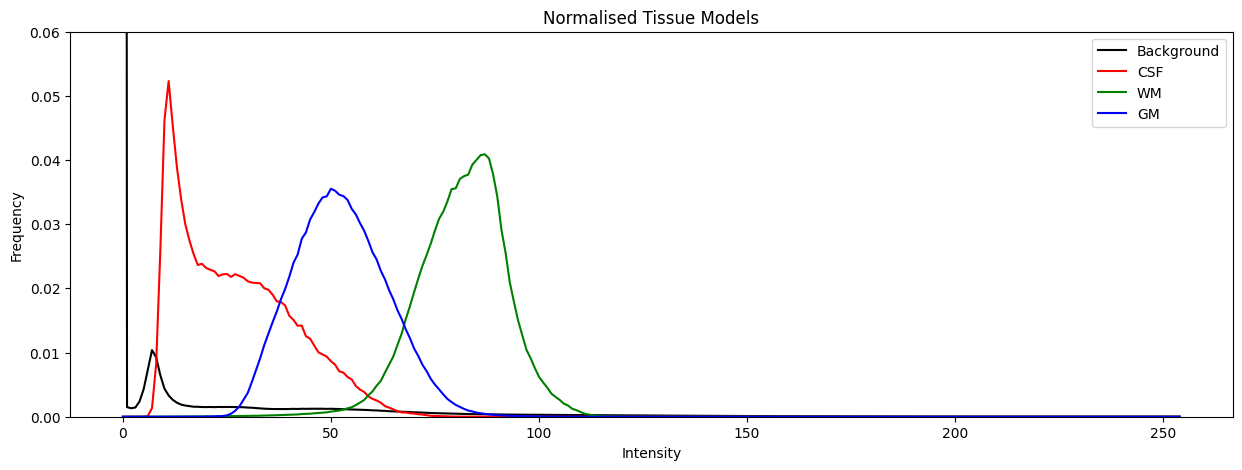

In [63]:
plt.figure(figsize=(15,5))

plt.plot(hist_bg_norm, color='black',  label='Background')
plt.plot(hist_csf_norm, color='red',  label='CSF')
plt.plot(hist_wm_norm, color='green', label='WM')
plt.plot(hist_gm_norm, color='blue',  label='GM')

plt.title('Normalised Tissue Models')
plt.xlabel('Intensity')
plt.ylabel('Frequency')
plt.legend(['Background', 'CSF','WM','GM'])
plt.ylim([0,0.06]) # we have to make a limit to the y-axis, the background values are so high
plt.grid = False

plt.savefig('figures/normalised-tissue-models')

plt.show()


Creating a probabilistic histogram

In [64]:
# we need to sum each pixel distribution from the 4 histograms to create a probabilistic histogram
histograms_combined     = np.vstack((hist_bg_norm, hist_csf_norm,hist_wm_norm, hist_gm_norm))
histograms_combined_sum = np.sum(histograms_combined, axis=0)

In [65]:
hist_bg_prob  = hist_bg_norm  / histograms_combined_sum
hist_csf_prob = hist_csf_norm / histograms_combined_sum
hist_wm_prob = hist_wm_norm / histograms_combined_sum
hist_gm_prob = hist_gm_norm / histograms_combined_sum

In [66]:
data = {
    # "hist_bg_prob": hist_bg_prob,
    "hist_csf_prob": hist_csf_prob,
    "hist_wm_prob": hist_wm_prob,
    "hist_gm_prob": hist_gm_prob
}

# Specify the name of the CSV file
csv_file = "tissue_model_probability_data.csv"

# Open the CSV file in write mode and write the data
with open(csv_file, 'w', newline='') as file:
    writer = csv.writer(file)
    # # Write the header row
    # writer.writerow(data.keys())
    # Write the data
    writer.writerows(zip(*data.values()))

print("Data has been saved to", csv_file)


Data has been saved to tissue_model_probability_data.csv


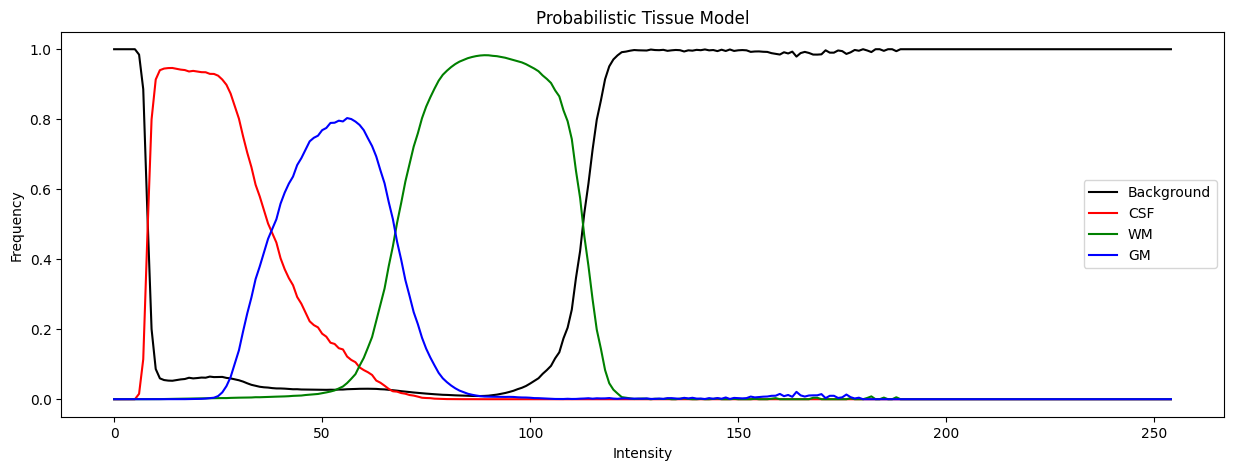

In [67]:
plt.figure(figsize=(15,5))

plt.plot(hist_bg_prob, color='black',  label='Background')
plt.plot(hist_csf_prob, color='red',  label='CSF')
plt.plot(hist_wm_prob, color='green', label='WM')
plt.plot(hist_gm_prob, color='blue',  label='GM')

plt.title('Probabilistic Tissue Model')
plt.xlabel('Intensity')
plt.ylabel('Frequency')
plt.legend(['Background', 'CSF','WM','GM'])

plt.grid = False
plt.savefig('figures/probabilistic-tissue-models')

plt.show()


## 8. Generating plots for the report

In [7]:
# Calculate the mean volumes
mean_csf, _ = NM.load_nifti('output/mean_csf.nii.gz')
mean_wm, _  = NM.load_nifti('output/mean_wm.nii.gz')
mean_gm, _  = NM.load_nifti('output/mean_gm.nii.gz')

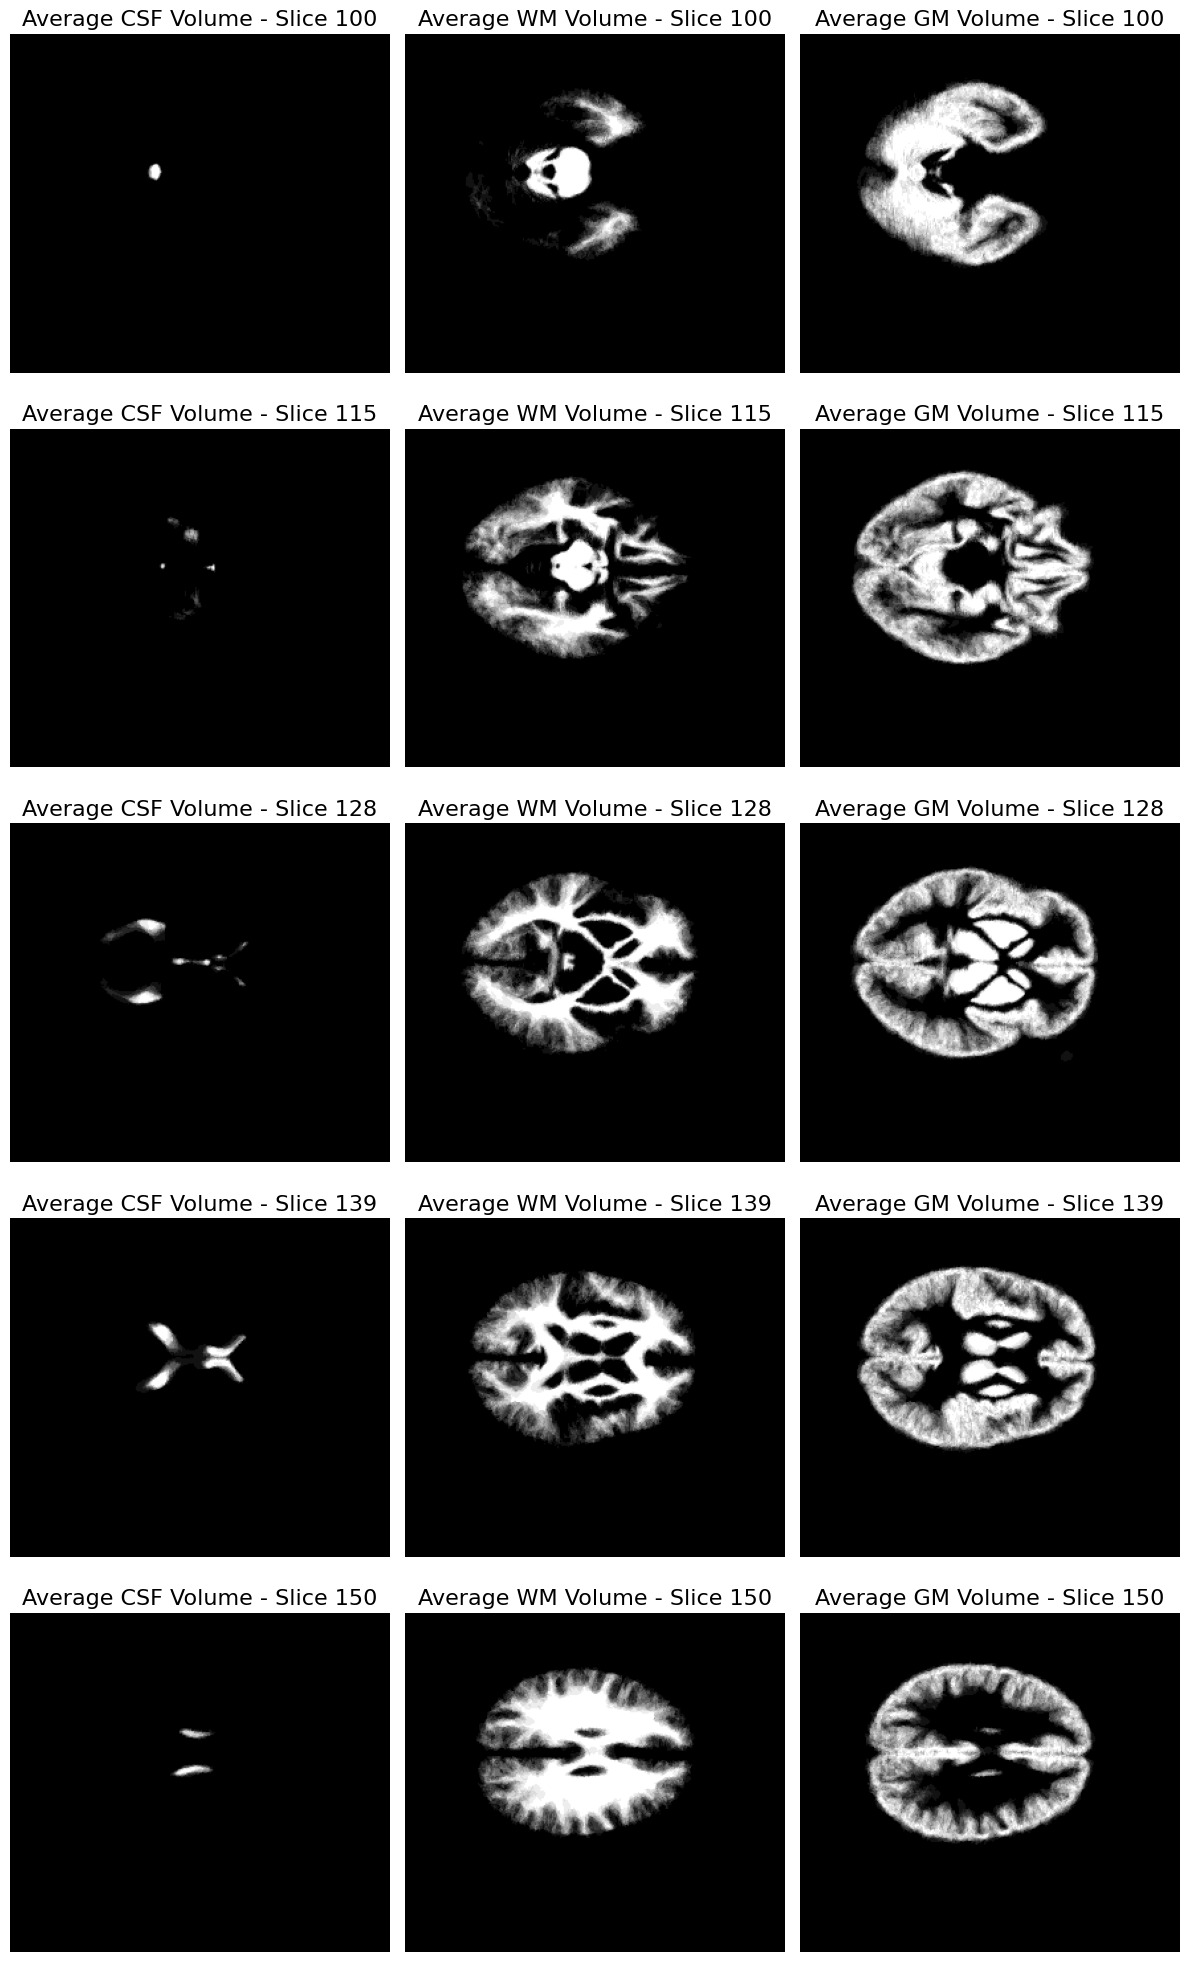

In [18]:
# Display multiple slices of the average probabilistic labels
NM.show_mean_volumes(mean_csf, mean_wm, mean_gm, slices=[100, 115, 128, 139, 150], export=True, filename="figures/Means-slices")

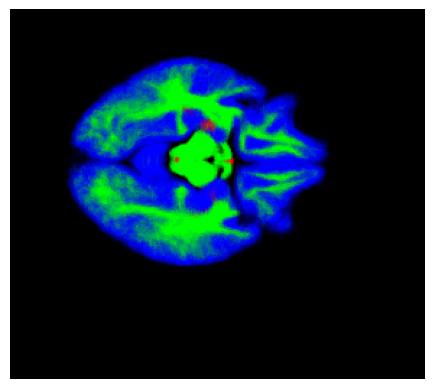

In [59]:
# Show combined probabilities as rgb
NM.show_combined_mean_volumes(mean_csf, mean_wm, mean_gm, slice_to_display=115, export=True, filename="Combined Averaged Volumes Slice 115")

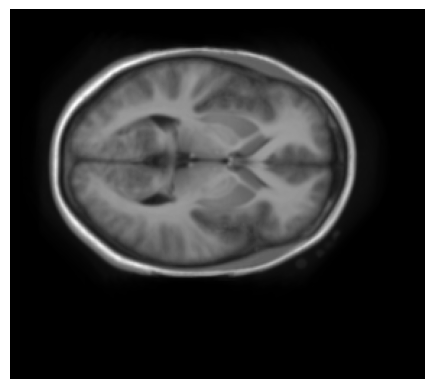

In [42]:
# loading the averaged intensity image
mean_intensity, _ = NM.load_nifti('output/mean_intensity.nii.gz')

NM.show_nifti(mean_intensity, title=f"Mean Intensity Image, Shape: {mean_intensity.shape}", slice=128, export=True, filename='figures/averaged-intensity')

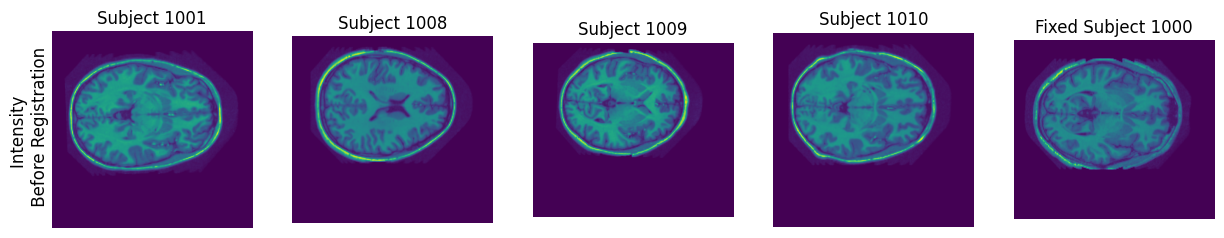

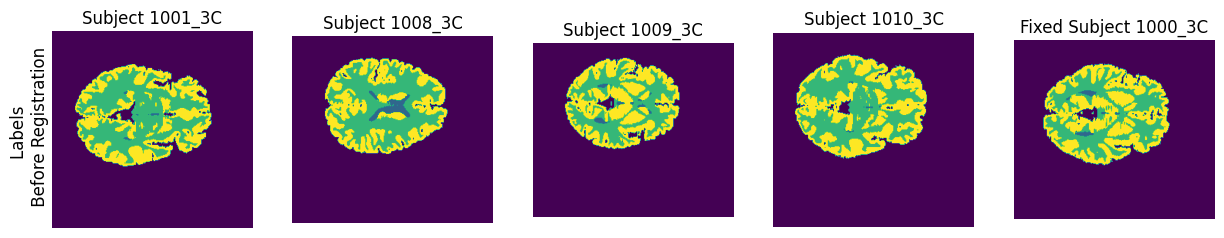

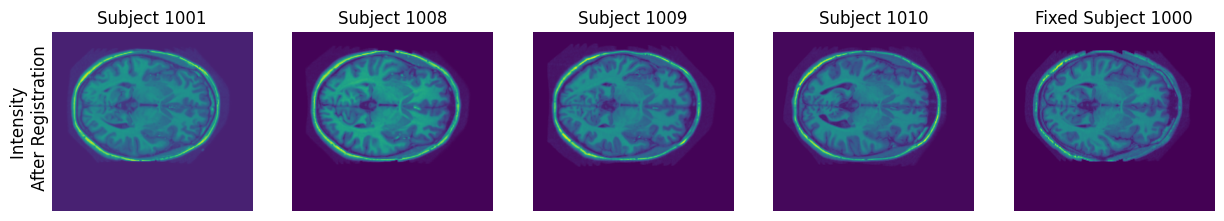

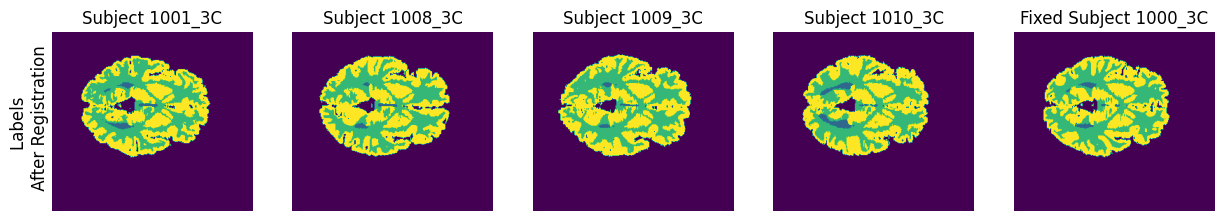

In [5]:
# display images before and after registration
training_path = 'training-set/training-images'
labels_path = 'training-set/training-labels'
output_dir = 'output/images/output_1000'
labels_output_path = 'output/labels'

excluded_names = ['1002', '1006', '1007', '1015', '1036']

training_volumes           = sorted(glob(os.path.join(training_path, "*.nii.gz"), recursive=True))
training_labels            = sorted(glob(os.path.join(labels_path, "*.nii.gz"), recursive=True))
intensities_volumes        = sorted(glob(os.path.join(output_dir, "**", "result.1.nii"), recursive=True))
transformed_labels_volumes = sorted(glob(os.path.join(labels_output_path, "**", "result.nii"), recursive=True))

training_volumes           = [path.replace('\\','/') for path in training_volumes if not any(name in path for name in excluded_names)]
training_labels            = [path.replace('\\','/') for path in training_labels if not any(name in path for name in excluded_names)]
intensities_volumes        = [path.replace('\\','/') for path in intensities_volumes if not any(name in path for name in excluded_names)]
transformed_labels_volumes = [path.replace('\\','/') for path in transformed_labels_volumes if not any(name in path for name in excluded_names)]

#################################################################
################ BEFORE REGISTERATION INTENSITY #################
#################################################################
# Define common x-axis label
fig, axes = plt.subplots(1, 5, figsize=(15, 3), sharey=True)
fig.text(0.11, 0.5, 'Intensity \n Before Registration', va='center', ha='center', rotation='vertical', fontsize=12)

# Load and display images in a loop
for i in range(5):
    if i == 4:
        filename = training_volumes[0]
        title = f'Fixed Subject {filename.split("/")[-1].split(".")[0]}'
    else:
        filename = training_volumes[1:][i]
        title = f'Subject {filename.split("/")[-1].split(".")[0]}'

    labels_nifti, _ = NM.load_nifti(filename)
    axes[i].imshow(labels_nifti[:, :, 125])
    axes[i].set_title(title)
    axes[i].axis('off')

# plt.savefig('figures/before-registration-intensity-results')


#################################################################
################## BEFORE REGISTERATION LABELS ##################
#################################################################
# Define common x-axis label
fig, axes = plt.subplots(1, 5, figsize=(15, 3), sharey=True)
fig.text(0.11, 0.5, 'Labels \n Before Registration', va='center', ha='center', rotation='vertical', fontsize=12)

# Load and display images in a loop
for i in range(5):
    if i == 4:
        filename = training_labels[0]
        title = f'Fixed Subject {filename.split("/")[-1].split(".")[0]}'
    else:
        filename = training_labels[1:][i]
        title = f'Subject {filename.split("/")[-1].split(".")[0]}'

    labels_nifti, _ = NM.load_nifti(filename)
    axes[i].imshow(labels_nifti[:, :, 125])
    axes[i].set_title(title)
    axes[i].axis('off')

# plt.savefig('figures/before-registration-labels-results')

#################################################################
################ AFTER REGISTERATION INTENSITY #################
#################################################################
# Define common x-axis label
fig, axes = plt.subplots(1, 5, figsize=(15, 3), sharey=True)
fig.text(0.11, 0.5, 'Intensity \n After Registration', va='center', ha='center', rotation='vertical', fontsize=12)

# Load and display images in a loop
for i in range(5):
    if i == 4:
        filename = training_volumes[0]
        title = f'Fixed Subject {filename.split("/")[-1].split(".")[0]}'
    else:
        filename = intensities_volumes[1:][i]
        title = f'Subject {training_volumes[1:][i].split("/")[-1].split(".")[0]}'

    labels_nifti, _ = NM.load_nifti(filename)
    axes[i].imshow(labels_nifti[:, :, 125])
    axes[i].set_title(title)
    axes[i].axis('off')

# plt.savefig('figures/after-registration-intensity-results')

#################################################################
################## AFTTER REGISTERATION LABELS ##################
#################################################################
# Define common x-axis label
fig, axes = plt.subplots(1, 5, figsize=(15, 3), sharey=True)
fig.text(0.11, 0.5, 'Labels \n After Registration', va='center', ha='center', rotation='vertical', fontsize=12)

# Load and display images in a loop
for i in range(5):
    if i == 4:
        filename = training_labels[0]
        title = f'Fixed Subject {filename.split("/")[-1].split(".")[0]}'
    else:
        filename = transformed_labels_volumes[1:][i]
        title = f'Subject {training_labels[1:][i].split("/")[-1].split(".")[0]}'

    labels_nifti, _ = NM.load_nifti(filename)
    axes[i].imshow(labels_nifti[:, :, 125])
    axes[i].set_title(title)
    axes[i].axis('off')
    
# plt.savefig('figures/after-registration-labels-results')

plt.show()
